In [1]:
# This code reproduce Real-World data results provided in Paper

# The Code require one data file from all the states, with three possible treatments. 
# One feature list file 

# After Preprocessing (IH)=Treatment = 0, OH = Treatment = 1, SS=Treatment = 2
# Label 0 = Safe, 1 = Maltreatment

In [2]:
__author__ = 'Sohaib Kiani'

import pandas as pd
import arff
from scipy.io.arff import loadarff
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ********************** Data Preprocessing ***************************

In [4]:
path ='D:/MachineLearning/ROM_Demo_Extracts/'
df=pd.read_csv(path + "Short_Stayers_20221215/Short_Stayers_Location_all.csv",header=None,low_memory=False)
f = open(path + "Short_Stayers_20210729/Feature_List.txt", 'r+')
lines =f.readlines()
features = []
for i in lines:
    features.append(i.strip())
f.close()
df.columns = features
df.Treatment = (df.Treatment + 1) % 3

print ("Available States",df.State.unique()) ## Need to exclude outlier states here
print (df.shape)

Available States [ 1  2  3  4  7  8  9 10 12 13 11]
(345583, 96)


In [5]:
# Provided one-hot-encoding of Race have issues. This code is to remove previous and regenerate one-hot-encoding of Race
df.drop(['Race_A','Race_B','Race_C','Race_D','Race_E','Race_F','Race_G','Race_H' ],axis=1,inplace = True,errors= 'ignore')
race_groups = ['Race_A','Race_B','Race_C','Race_D','Race_E','Race_F','Race_G','Race_H']
# drop rows with NaN values in "Race" column
df = df.dropna(subset=['Race'])
# convert "Race" column to uppercase
df['Race'] = df['Race'].str.upper()
print (df.loc[:,'Race'].tail())
print (df['Race'].unique())

# perform one-hot encoding on "Race" column
race_dummies = pd.get_dummies(df['Race'], prefix='Race')
# concatenate the original DataFrame with the one-hot encoded columns
df = pd.concat([df, race_dummies], axis=1)
# find the rows where multiple columns have value 1
multi_ones = df[df.loc[:,race_groups].sum(axis=1) > 1]
# print the resulting DataFrame
print('Rows with multiple races',multi_ones.shape)
print (df.loc[:,race_groups].tail())

345578    E
345579    G
345580    C
345581    E
345582    G
Name: Race, dtype: object
['H' 'E' 'C' 'G' 'A' 'D' 'B' 'F']
Rows with multiple races (0, 98)
        Race_A  Race_B  Race_C  Race_D  Race_E  Race_F  Race_G  Race_H
345578       0       0       0       0       1       0       0       0
345579       0       0       0       0       0       0       1       0
345580       0       0       1       0       0       0       0       0
345581       0       0       0       0       1       0       0       0
345582       0       0       0       0       0       0       1       0


In [6]:
# ********************** Feature Engineering ***************************

In [7]:
Irrelevant_feature = ['Episode_YYYYMM','Episode_Type','In_Home_End','p_fc_6mos','Episode_End_Reason','Short_FC_CT','No_Stayer','Episode_Time_Days','Less_60','Less_90','Placement_Setting_Type','Race','Hispanic','Location_Code01','Location_Code02','Location_Code03','Location_Code04','Location_Code05','Location_Code06','Location_Code07','Location_Code08','Location_Code09','Location_Code10','Location_Code11','Location_Code12','Location_Code13']
hidden_features = ['ct_Placements','Placement_Setting_Type1','Placement_Setting_Type2','Placement_Setting_Type3','Placement_Setting_Type4','Placement_Setting_Type5','Placement_Setting_Type6','Placement_Setting_Type7','Placement_Setting_Type8','Placement_Setting_Type9','Removal_Physical_Abuse','Removal_Sexual_Abuse','Removal_MalTreatment','Removal_Parent_Drug_Abuse','Removal_Parent_Alcohol_Abuse','Removal_Inadequate_Housing','Removal_Parent_Incapacity','Removal_Parent_Incarceration','Removal_Child_Behavior','Removal_Child_Disability',
        'Removal_Child_Drug_Abuse',
        'Removal_Child_Alcohol_Abuse',
        'Removal_Parent_Death',
        'Removal_Abandon',
        'Removal_Relinquishment',
        'Removal_Abuse',
        'Removal_Neglect',
        'Removal_Parent',
        'Removal_Child',
        'Removal_Drug_Alcohol','Disability_Diagnosis',
        'Disability_Emotional',
        'Disability_MR',
        'Disability_Other',
        'Disability_Physical',
        'Disability_Sensory','Race_A','Race_B','Race_C','Race_D','Race_E','Race_F','Race_G','Race_H','Gender']
df_PP = df.copy()


# ************* Filtering*****************
###Exclude irrelevant states
print (df_PP['State'].unique())
exclude_state = [7,11,12,13]
df_PP = df_PP[~df_PP['State'].isin(exclude_state)]
print (df_PP['State'].nunique())

### Filtering out few exceptional cases where child was move to foster care too soon to be recognised as in-home
df_PP = df_PP[(df_PP.Treatment != 2) | (df_PP.In_Home_End != 2) | (df_PP.Episode_Time_Days > 365)]

### extract Label
df_PP['Label'] = df_PP['Safe12_Outcome_Code']
df_PP.drop(['Safe12_Outcome_lbl','Safe6_Outcome_lbl','Safe6_Outcome_Code','Safe12_Outcome_Code'],axis=1,inplace=True)
df_PP = df_PP[df_PP.Episode_Type != 3]         # Get Rid of Non-fed types

##Remove Irrelevant features 
df_PP.drop (Irrelevant_feature, axis = 1, inplace = True)

#************Fix Columns DataTypes********* 
### Tackle Nan 
df_PP.fillna(0,inplace = True)
### for bool values True, false
df_PP = df_PP * 1

###columns with string(yes,no) convert them into discrete(0,1)
filteredColumns = df_PP.dtypes[df_PP.dtypes == np.object]
# list of columns whose data type is object i.e. string
listOfColumnNames = list(filteredColumns.index)
for col in listOfColumnNames:
    replace_map={col:{'Yes':1, 'No':0}}
    df_PP.replace(replace_map,inplace=True)
    df_PP[col] = pd.to_numeric(df_PP[col], errors='coerce')


#************ Reorder Columns ******************
#shift hidden features make exclusion/inclusion easier while training, 
temp_hidden = df_PP[hidden_features]
df_PP.drop (hidden_features, axis = 1, inplace = True)
df_PP = pd.concat([df_PP,temp_hidden],axis=1)

#Shift Label and Treatment to the end as well
Label = df_PP.pop('Label')
Treatment = df_PP.pop('Treatment')
df_PP['Treatment'] = Treatment
df_PP['Label'] = (Label + 1)%2 
policies = df_PP['State'].nunique()

#df_PP.drop('State',axis=1,inplace=True)
v_dim = df_PP.shape[1] - len(hidden_features) - 3 #Exclude Treatment, Label and State
print (policies,v_dim)
print ("Total Features",df_PP.shape[1]-3)
print ("Observed Features",v_dim)
print ("Hidden Features",len(hidden_features))
#print (df_PP.columns)

[ 1  2  3  4  7  8  9 10 12 13 11]
7
7 21
Total Features 66
Observed Features 21
Hidden Features 45


In [8]:
# ********************** Data Visualization ***************************

In [9]:

###Excluding Location_code_11 due to very few 'In home' Samples 
###Excluding Location_Code_7,12,13 are exception due to policies and not contributing anything in the experiment good/bad.
treat_map = {0:'In Home',1:'Out of Home',2:'Short Stayer'}
dfLocation_stat = pd.DataFrame(columns = ['Site','In Home','Short Stayer','Out of Home'])
dfLocation_outcome = pd.DataFrame(columns = ['Site','Fail_Rate'])
dfLocation_SS = pd.DataFrame(columns = ['Site','Accept_Rate'])
site_name = ['A','B','C','D','E','F','G','H','I']
site_index = 0
for i in range (1,14):
    if i == 5 or i == 6 or i == 7 or i==11 or i==12 or i == 13:
        continue
    temp = 'Location_Code'
    code = str(i)
    location = temp + '0'+ code if len(code) == 1 else temp + code
    n = 5000
    print (location)
    dfSubset = df[df[location] == 1].sample(n)
    stat = {'Site':site_name[site_index]}
    for k in range(3):
        stat[treat_map[k]] = dfSubset[ dfSubset.Treatment == k].shape[0]
    dfLocation_stat = dfLocation_stat.append(stat,ignore_index = True)
    
    dict_row = {'Site':site_name[site_index]}
    dict_row['Fail_Rate'] = ((dfSubset.Treatment == 0) & (dfSubset.Safe12_Outcome_Code == 0)).sum()/n
    #dfLocation_outcome = dfLocation_outcome.append(dict_row,ignore_index = True)
    
    #dict_row = {'Site':location}
    dict_row['Accept_Rate'] = (dfSubset.Treatment == 0).sum()/n
    dfLocation_SS = dfLocation_SS.append(dict_row,ignore_index = True)
    site_index += 1                        

dfLocation_stat['In Home'] = dfLocation_stat['In Home']/5000
dfLocation_stat['Short Stayer'] = dfLocation_stat['Short Stayer']/5000
dfLocation_stat['Out of Home'] = dfLocation_stat['Out of Home']/5000
print (dfLocation_stat.head())

Location_Code01
Location_Code02
Location_Code03
Location_Code04
Location_Code08
Location_Code09
Location_Code10
  Site In Home Short Stayer Out of Home
0    A  0.6348        0.054      0.3112
1    B  0.7188       0.0264      0.2548
2    C  0.7154       0.0088      0.2758
3    D  0.6138       0.0134      0.3728
4    E   0.249       0.3044      0.4466


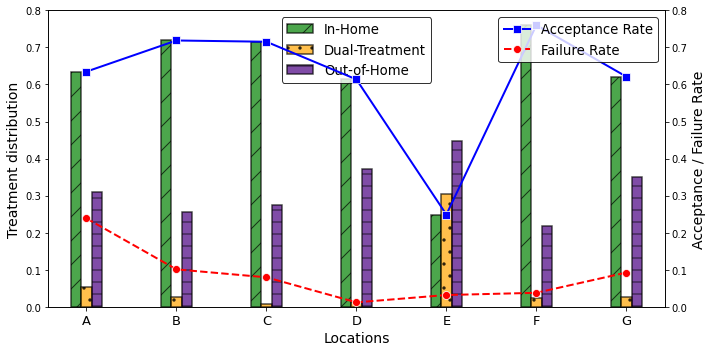

In [20]:
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

# create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the first dataframe on the first y-axis
bars = dfLocation_stat.set_index('Site').plot(kind='bar', ax=ax1, alpha=0.7, edgecolor='black', width=0.35,
                                       linewidth=1.5, color=['green', 'orange', 'indigo'])

# set hatch styles for each bar individually
patterns = ['/', '.', '-']

for i in range(3):
    for loc in range(7):
         bars.patches[i*7 + loc].set_hatch(patterns[i])

# create a second y-axis with a different scale
ax2 = ax1.twinx()

# plot the Accept_Rate and Fail_Rate columns on the second y-axis as line plots
sns.lineplot(x='Site', y='Accept_Rate', data=dfLocation_SS, ax=ax2, marker='s', linewidth=2,markersize = 8, color='blue', linestyle='solid')
sns.lineplot(x='Site', y='Fail_Rate', data=dfLocation_SS, ax=ax2, marker='o', linewidth=2, markersize = 8, color='red', linestyle='dashed')

# set the limits for the y-axes
ax1.set_ylim([0, .8])
ax2.set_ylim([0, .8])

# add labels to the bars and lines
ax1.set_xticklabels(dfLocation_stat['Site'], rotation=0)
ax1.set_xlabel('Locations',fontsize = 14)
ax1.set_ylabel('Treatment distribution', fontsize = 14)
ax2.set_ylabel('Acceptance / Failure Rate', fontsize = 14)

# add a legend
ax1.legend(labels=['In-Home', 'Dual-Treatment', 'Out-of-Home'], loc='upper center',fontsize=13.2, frameon=True,edgecolor='black')
ax1.tick_params(axis='x', labelsize=13)
ax2.legend(loc='upper right',labels = ['Acceptance Rate','Failure Rate'],fontsize = 13.2, frameon=True,edgecolor='black')

plt.tight_layout()
plt.savefig("dataset.png")

In [11]:
# ********************** Training & Evaluation ***************************

Available States [ 1  2  3  4  8  9 10]
Estimating FR for each state
----------------
Test Site Location_Code01
Training DR over other Sites:
Calibration Performed
DM Train Shape (4474, 66)

 Train DR using all treatment Samples

 Train DM using all treatment train Samples
Result:
Historical FR:0.23253747488796167 as compare to Our FR:0.022716736207695872
----------------
Test Site Location_Code02
Training DR over other Sites:
Calibration Performed
DM Train Shape (6556, 66)

 Train DR using all treatment Samples

 Train DM using all treatment train Samples
Result:
Historical FR:0.09908463144371286 as compare to Our FR:0.00048177292436165086
----------------
Test Site Location_Code03
Training DR over other Sites:
Calibration Performed
DM Train Shape (6513, 66)

 Train DR using all treatment Samples

 Train DM using all treatment train Samples
Result:
Historical FR:0.08074690256590686 as compare to Our FR:0.002689050287753512
----------------
Test Site Location_Code04
Training DR over ot

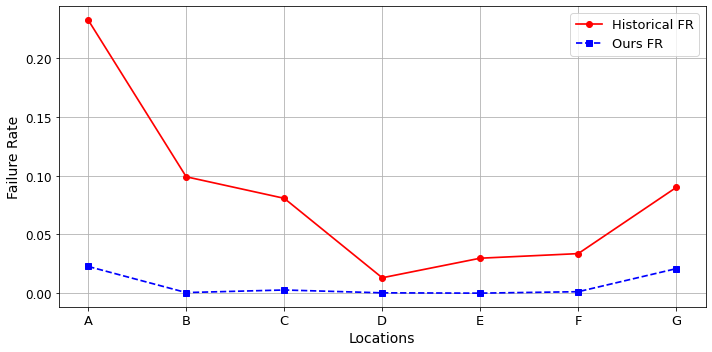

In [23]:
# Evaluation Methodology 1 - Comparison with Human Decision Maker 

from ATE_Estimator import ATE_Learner
from Double_Robust import DRLearner
from utils import *
from sklearn.model_selection import cross_val_predict, KFold, train_test_split

df_Result = pd.DataFrame()
print ("Available States",df_PP.State.unique())

#Estimate Labels for Short-Stayers
ATE_est = ATE_Learner(df_PP,policies,v_dim)
df_PP['CLabel'] = df_PP['Label'] + ATE_est.intercept + np.array(df_PP.iloc[:,:v_dim]).dot(ATE_est.calib_param)
site_name = ['A','B','C','D','E','F','G','H','I']
site_index = 0

print("Estimating FR for each state")
for tState in range(1,11):
    
    if tState == 5 or tState == 6 or tState == 7 :
        continue
    print ("----------------")
    temp = 'Location_Code'
    code = str(tState)
    location = temp + '0'+ code if len(code) == 1 else temp + code
    print ("Test Site",location)
    print ("Training DR over other Sites:")
    #train, test = train_test_split(df_PP, test_size=0.30, random_state=3, shuffle=True)
    train = df_PP[(df_PP.State != tState)].copy()   ## 5 and 6 are outliers
    test = df_PP[(df_PP.State == tState)].copy()
    train.pop('State')
    train.pop('CLabel')
    test.pop('State')
    #print (train.shape,test.shape)


    train_DR, test_DR = train_test_split(train, test_size=0.20, random_state=3, shuffle=True)
    #print ("Number of States in Training",policies)
    ATE_est = ATE_Learner(train_DR,policies,v_dim)

    DR = DRLearner(train_DR,test_DR,'C',v_dim,ATE_est)

    mask = test.Treatment == 2
    #test_2 = test[test.Treatment == 2]
    test.loc[mask,'Label'] = test.loc[mask,'CLabel']
    test.pop('CLabel')


    AR = (test.Treatment == 0).sum()/test.shape[0]
    FR = ((test.Treatment == 0) & (test.Label == 1)).sum()/test.shape[0]

    test_temp = pd.DataFrame()
    test_temp['Label'] = test.pop('Label')
    test_temp['Treatment'] = test.pop('Treatment')

    test_temp['Pred'] = DR.DR_algo.predict(test.iloc[:,:v_dim])
    test_sorted = test_temp.sort_values(by = 'Pred')
    IH_pred_samples = int(test_sorted.shape[0] * AR)
    #print(IH_pred_samples)
    #print (test_sorted.tail())
    test_prediction = test_sorted.iloc[:IH_pred_samples,:].copy()
    New_FR = (test_prediction.Label > 0.7).sum()/ test.shape[0]

    dict_row = {'Sites': site_name[site_index], 'Historical FR': FR, 'Our FR':New_FR}
    df_Result = df_Result.append(dict_row,ignore_index = True)
    print ("Result:")
    print (f'Historical FR:{FR} as compare to Our FR:{New_FR}')
    site_index += 1
df_PP.drop(['CLabel'],inplace =True,axis=1)

# Plot Method 1 - Comparison with Human Decision Maker
print (df_Result)
fig, ax = plt.subplots(figsize=(10, 5))

x = df_Result['Sites']
y1 = df_Result['Historical FR']
y2 = df_Result['Our FR']

ax.plot(x, y1, marker='o',markersize = 6, linestyle='solid', linewidth=1.7, color='red', label='Historical FR')
ax.plot(x, y2, marker='s', markersize = 6,linestyle='dashed', linewidth=1.7, color='blue', label='Ours FR')

plt.xlabel("Locations", fontsize=14)
plt.ylabel("Failure Rate", fontsize=14)
plt.xticks(rotation=0, fontsize=13)
plt.yticks(fontsize=12)
ax.legend(loc="upper right", fontsize=13)

ax.grid(True)  # add grid to the plot

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)  # squeeze the y-axis a little bit

plt.tight_layout()
plt.savefig("Method1.png")

In [24]:
#Testing Methodology 2 - Test over In-home samples of Outlier State with high FR
from ATE_Estimator import ATE_Learner
from Double_Robust import DRLearner
from utils import *
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
import warnings
warnings.filterwarnings('ignore')

df_Result_M1 = pd.DataFrame(columns= ['Location','SP','RA','DR'])
train = df_PP[(df_PP.State != 1)].copy()   
train = train.groupby('State').head(5000)
print (train.shape)
train['Label'] = train['Label'].replace({0:-1})
print ("Number of States in Training",train.State.nunique())
train.pop('State')

#Train
train_DR, test_DR = train_test_split(train, test_size=0.20, random_state=3, shuffle=True)
ATE_est = ATE_Learner(train_DR,policies,v_dim)
DR = DRLearner(train_DR,test_DR,'C',v_dim,ATE_est)

#Test
for t_State in [1]:
    test = df_PP[(df_PP.State == t_State)]
    test['Label'] = test['Label'].replace({0:-1})
    test.pop('State')

    test_0 = test[test.Treatment == 0]
    y_test = test_0.pop('Label')       #### testing it against desired label
    T_test = test_0.pop('Treatment')

    X_test = test_0.iloc[:,:v_dim]
    MSE_score_DR = mse(DR.DR_algo,X_test,y_test)  
    MSE_score_RA = mse(DR.RA_algo,X_test,y_test)
    MSE_score_SP = mse(DR.SP_algo,X_test,y_test)    
    temp = 'Location_Code'
    code = str(t_State)
    location = temp + '0'+ code if len(code) == 1 else temp + code
    
    dict_Row = {'SP':MSE_score_SP,'DR': MSE_score_DR,'Location':location, 'RA':MSE_score_RA,}
    df_Result_M1 = df_Result_M1.append(dict_Row,ignore_index=True)

print (df_Result_M1)

(30000, 69)
Number of States in Training 6
Calibration Performed
DM Train Shape (1607, 66)

 Train DR using all treatment Samples

 Train DM using all treatment train Samples
          Location       SP        RA        DR
0  Location_Code01  0.81428  0.687753  0.687764


In [25]:
### Methodology 3: Counterfactual Evaluation
from ATE_Estimator import ATE_Learner
from Double_Robust import DRLearner
from utils import *
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from lightgbm import LGBMRegressor

train = df_PP.copy()   ## 1,5 and 6 are outliers
train.pop('State')
train['Label'] = train['Label'].replace({0:-1})
train_DR, test_DR = train_test_split(train, test_size=0.30, random_state=3, shuffle=True)
print ("Number of States in Training",policies)
ATE_est = ATE_Learner(train_DR,policies,v_dim)

algo = ['DR','RA','SP']
DR = DRLearner(train_DR,test_DR,'C',v_dim,ATE_est)
Y = test_DR.pop('Label')
T = test_DR.pop('Treatment')
for a in algo:
    Y[T == 2] += ATE_est.intercept
    Y[T == 2] += np.array(test_DR[T == 2].iloc[:,:v_dim]).dot(ATE_est.calib_param)
    
    if a == 'DR':
        Y_pred = DR.DR_algo.predict(test_DR.iloc[:,:v_dim])
    elif a == 'RA':
        Y_pred = DR.RA_algo.predict(test_DR.iloc[:,:v_dim])
    else:
        Y_pred = DR.SP_algo.predict(test_DR.iloc[:,:v_dim])    
    
    y_pred = Y_pred[T==2]
    mse_y = list(map(lambda x,y: (x-y)**2,Y[T==2],y_pred))
    X_train = test_DR[T == 2]
    eta_algo = LGBMRegressor().fit(X_train,mse_y)
    eta = eta_algo.predict(test_DR)
    pi =  DR.PS_algo.predict(test_DR)
    phi = []
    for i in range (0,test_DR.shape[0]):
        if T.iloc[i] == 0:
            phi.append((Y.iloc[i] - Y_pred[i])**2)
        else:
            if T.iloc[i] == 2:
                phi.append((1/(pi[i]))*(( Y.iloc[i] - Y_pred[i])**2 - eta[i]) + eta[i])
            else:
                phi.append(eta[i])
    print (a,np.sum(phi)/test_DR.shape[0])

Number of States in Training 7
Calibration Performed
DM Train Shape (5850, 66)

 Train DR using all treatment Samples

 Train DM using all treatment train Samples
DR 0.2667804308227757
RA 0.41619460330314145
SP 0.8559459470885894
